# Second Machine Learning Approach for Physio Data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import functionsMasterProjectMeinhart as fmpm

## Splitting the signals into sections and taking them directly as features for ML

One repetition is considered as one data point for ML.

In total we have approximately 2700 data points $\rightarrow$ (5 + 10 + 15) rep. x 9 sub. x 10 exerc. (a few more or less because of incorrect exercise repetitions of some subjects).

The signals will be split into a defined number of equally distributed sections. For each section the mean will be calculated. Hence, all received signal arrays have same length.

***The first step is to extract all data from the database (start_time, stop_time, csv-file), ***

***and to save them in a dictionary with the exercise abbreviations as keys.***

In [3]:
db_name='DataBase_Pysio.db' # database name

exercise_abbrs = ['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2'] # exercise abbreviations


# Connect to an existing database
conn = sqlite3.connect(db_name)
cur = conn.cursor()

# dictionary with the exercise abbreviation as key
data_points = {}

for key in exercise_abbrs:
    # sql command to extract data
    query_sql = """
        SELECT r.start_time, r.stop_time, e.csv_file
        FROM subjects s
        INNER JOIN exercises e
        ON s.id = e.subject_id
        INNER JOIN paradigms p
        ON p.id = e.paradigm_id
        INNER JOIN repetitions r
        ON e.id = r.exercise_id
        WHERE p.abbreviation = '{}'
        """.format(key)

    # get data from data base and close connection
    data_points[key] = pd.read_sql_query(query_sql, conn)
    
conn.close()

In [3]:
print('Head of one loaded data frame as an example:')
data_points['RF'].head()

Head of one loaded data frame as an example:


,start_time,stop_time,csv_file
0,1.1482924107142871,3.699122023809525,subject01_RF_05.csv
1,3.699122023809525,6.49581473214286,subject01_RF_05.csv
2,6.49581473214286,9.384706101190478,subject01_RF_05.csv
3,9.384706101190478,12.073833705357146,subject01_RF_05.csv
4,12.073833705357146,14.809060639880954,subject01_RF_05.csv


In [4]:
print('Length of the individual data frames:')
count = 0
for key in exercise_abbrs:
    print(key + ':\t' + str(data_points[key].shape[0]))
    count += data_points[key].shape[0]
print('total:\t' + str(count))

Length of the individual data frames:
RF:	269
RO:	270
RS:	270
LR:	271
BC:	273
TC:	273
MP:	272
SA:	273
P1:	270
P2:	269
total:	2710


As we can see from above, there are a few more than 2700 data points, because obviously some exercises were performed with too much repetitions. 

*** Function to split signals into equally distributed sections and calculating the mean ***

In [5]:
def split_into_sections(signal_data, num_sec=20, signals=['Acc','Gyr']):
    '''This Function splits the input signals data into a defined number 
    of equally distributed sections. For each signal and section the mean is calculated,
    and afterwards returned by means of a dictionary.
    
    Parameters
    ----------
    signal_data : dict
        Dictionary with the signals in the signals-argument as keys.
    
    num_sec : int
        Number of sections to split the signals.
        
    signals : list
        Keys to select signals in the signal_data dictionary.
        If no keys are provided, all keys of the signal_data
        dictionary are taken.
    
    Returns
    -------
    Dictionary with section means for each signal --> keys are same as the selected
    in the list "signals".
    '''
    
    # if no signals are given as keys, select all keys of the input dictionary
    if not signals:
        signals = [*signal_data]
    
    # number of input data points of each signal (signals have to be of the same length --> take index 0)
    len_signals = np.shape(signal_data[signals[0]])[0]
    
    # get indices of the sections (+1 due to start and end index of each section)
    sec_ind = np.linspace(0, len_signals, num_sec+1).round().astype(int)
    
    # dicitonary to save sections means for each signal
    section_means = {}

    for signal in signals:
        # generate row with zeros in order to use np.vstack afterwards
        section_means[signal] = np.zeros([1, np.shape(signal_data[signal])[1]])

        # add the mean of each section
        for ii in range(len(sec_ind)-1):
            section_means[signal] = np.vstack([section_means[signal], 
                                               np.mean(signal_data[signal][sec_ind[ii]:sec_ind[ii+1]], axis=0)])

        # delete the first row with the zeros
        section_means[signal] = np.delete(section_means[signal], 0, axis=0)
        
    return section_means

*** Load the data and split them into sections***

The number of features depends on the number of sections and the number of signals (3 x Acc + 3 x Gyr).

Hence, for 20 sections we get 120 features $\rightarrow$ (3 x Acc + 3 x Gyr) x 20 sections

In [11]:
number_sections = 20 # number of sections to split the signals

csv_dir='E:\Physio_Data_Split_Exercise_done' # directory of csv files
sampling_rate = 256 # [Hz]
signals = ['Acc','Gyr'] # signals which shall be considered for the mean calculation

feature_csv_file = '1_ML_Approach_Features/features_sections.csv' #  csv-file to save the features

# putting the header of the feature-file together
header_string = 'label;' # first column contains the labels

for sig in signals:
    for ax in ['_x','_y','_z']:
        for ii in range(number_sections):
            header_string +=  sig + ax + '_{:02}'.format(ii+1) + ';'

# remove last separator (;)
idx_last_sep = header_string.rfind(";")
header_string =  header_string[:idx_last_sep]

# write header to file
with open(feature_csv_file, 'w') as feature_file:
    feature_file.writelines(header_string + '\n')


# go through all exercises
for ex in exercise_abbrs:
    
    # go through all repetitions (data points) of the current exercise
    for ii in range(len(data_points[ex])):
        
        # join file path
        file_path = os.path.join(csv_dir, data_points[ex]['csv_file'][ii])
        
        # load the signal data of the corresponding time range of the current repetition
        selected_data = fmpm.get_sensor_data(in_file = file_path, 
                                             signals = signals, 
                                             sampling_rate = sampling_rate, 
                                             start_time = float(data_points[ex]['start_time'][ii]), 
                                             stop_time = float(data_points[ex]['stop_time'][ii]))
         
        # calculate the corresponding section means of the current repetition
        section_means = split_into_sections(signal_data = selected_data,
                                            num_sec = number_sections,
                                            signals = signals)
        
        # string to write data of the current data point to the csv-file
        data_point_string = ex + ';' # first column contains the label
        
        # copy section mean values to string
        for sig in signals:
            for jj in [0,1,2]: # x, y, z comp. of the corresponding signal
                for ll in range(number_sections):
                    
                    # append to string for writing to csv file (5 decimals)
                    data_point_string += "{:.5f};".format(section_means[sig][ll,jj])
                    
        # remove last separator (;)
        idx_last_sep = data_point_string.rfind(";")
        data_point_string =  data_point_string[:idx_last_sep]
        
        # append values of current data point to file
        with open(feature_csv_file, 'a') as feature_file:
            feature_file.writelines(data_point_string + '\n')
                    

***Now all the features are calculated and saved to a csv-file. Let's now load the feature data with pandas.***

In [12]:
feature_csv_file = '1_ML_Approach_Features/features_sections.csv'
feature_data = pd.read_csv(feature_csv_file, skiprows=0, sep=';')

In [13]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Columns: 121 entries, label to Gyr_z_20
dtypes: float64(120), object(1)
memory usage: 2.5+ MB


In [14]:
feature_data.head()

,label,Acc_x_01,Acc_x_02,Acc_x_03,Acc_x_04,Acc_x_05,Acc_x_06,Acc_x_07,Acc_x_08,Acc_x_09,...,Gyr_z_11,Gyr_z_12,Gyr_z_13,Gyr_z_14,Gyr_z_15,Gyr_z_16,Gyr_z_17,Gyr_z_18,Gyr_z_19,Gyr_z_20
0,RF,-0.88836,-0.99646,-1.02021,-0.66443,-0.26080,0.13043,0.44185,0.60414,0.62367,...,-77.94697,-122.77462,-143.82617,-166.58902,-146.50000,-122.16797,-94.47538,-32.60417,-11.41016,1.83523
1,RF,-0.92166,-0.93620,-1.01498,-0.99034,-0.69744,-0.27005,0.07515,0.36391,0.55178,...,-26.75174,-89.55208,-146.36607,-165.08507,-169.20139,-120.53993,-80.79688,-51.69821,-1.85069,8.97743
2,RF,-0.91815,-0.87466,-1.01370,-0.88283,-0.62962,-0.10910,0.19482,0.39330,0.53644,...,-34.30208,-86.99493,-121.62669,-140.86149,-153.22466,-132.71622,-94.19932,-42.53209,3.47128,2.54730
3,RF,-0.93641,-0.90483,-0.96628,-0.99289,-0.79710,-0.41034,-0.01136,0.25777,0.46615,...,-47.41786,-81.34743,-108.54464,-136.09926,-146.68036,-133.19118,-117.08214,-65.66360,-15.07500,10.29412
4,RF,-0.91934,-0.95460,-0.94056,-0.79266,-0.46904,-0.06963,0.14795,0.39058,0.51182,...,-28.08036,-66.05893,-96.75714,-123.46964,-123.80357,-108.53929,-107.76607,-83.72500,-34.83036,7.36607


*** Let's quickly check visually the correlation between a few features (not necessary)***

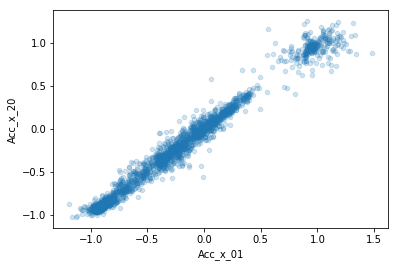

In [15]:
feature_data.plot(kind="scatter", x="Acc_x_01", y="Acc_x_20",alpha=0.2)
plt.show()

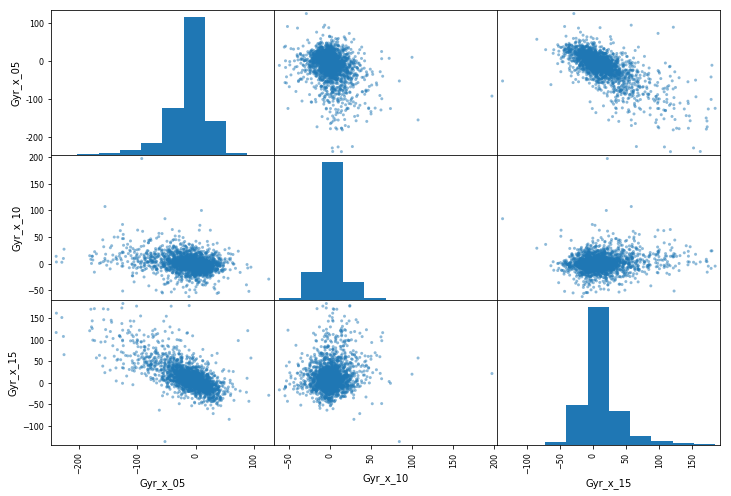

In [18]:
from pandas.plotting import scatter_matrix

attributes = ["Gyr_x_05", "Gyr_x_10", "Gyr_x_15"]
scatter_matrix(feature_data[attributes], figsize=(12, 8));

## Classification

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [20]:
# get feature matrix X
X = feature_data.values[:,1:]
np.shape(X)

(2710, 120)

In [21]:
# dictionary for labels
label_ex = {'RF':0,
            'RO':1,
            'RS':2,
            'LR':3,
            'BC':4,
            'TC':5,
            'MP':6,
            'SA':7,
            'P1':8,
            'P2':9}

# get label array with labels (0 ... 9)
y = [label_ex[feature_data.values[ii,0]] for ii in range(len(feature_data.values[:,0]))]
np.shape(y)

(2710,)

### Split the data points  into train (75%) and test (25%) data sets

Use *stratify=y* to ensure that there is approximately the same number of each label (exercise) in the training set.  

In [22]:
# split the data in train and test set (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
print('Train set shape: {}'.format(np.shape(X_train)))
print('Test set shape:  {}'.format(np.shape(X_test)))

Train set shape: (2032, 120)
Test set shape:  (678, 120)


In [23]:
def print_precision_recall_accuracy():
    print('Exercise\tPrecision [%]\tRecall [%]\tAccuracy[%]')
    
    for ex in exercise_abbrs:
        TP = sum((y_pred == label_ex[ex]) & (np.array(y_test) == label_ex[ex])) # True Positives
        TN = sum((y_pred != label_ex[ex]) & (np.array(y_test) != label_ex[ex])) # True Negatives
        FP = sum((y_pred == label_ex[ex]) & (np.array(y_test) != label_ex[ex])) # False Positives
        FN = sum((y_pred != label_ex[ex]) & (np.array(y_test) == label_ex[ex])) # False Negatives

        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        accuracy = (TP+TN) / (TP+TN+FP+FN)
        
        print('  '+ ex +'\t\t  {:6.2f}'.format(precision*100)+ \
              '\t  {:6.2f}'.format(recall*100)+'\t  {:6.2f}'.format(accuracy*100))

### Random Forest Classifier

In [24]:
# apply a random forest classifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=40, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

print('Total Accuracy: {:.5f}'.format((accuracy_score(y_test, y_pred))))

Total Accuracy: 0.99558


In [25]:
print_precision_recall_accuracy()

Exercise	Precision [%]	Recall [%]	Accuracy[%]
  RF		  100.00	   95.52	   99.56
  RO		   95.77	  100.00	   99.56
  RS		  100.00	  100.00	  100.00
  LR		  100.00	  100.00	  100.00
  BC		  100.00	  100.00	  100.00
  TC		  100.00	  100.00	  100.00
  MP		  100.00	  100.00	  100.00
  SA		  100.00	  100.00	  100.00
  P1		  100.00	  100.00	  100.00
  P2		  100.00	  100.00	  100.00


In [26]:
# display the misclassified data points

ind_misclassified = np.flatnonzero(y_test != y_pred) # indices of misclassified data points

exercise_abbrs = ['RF','RO','RS','LR','BC','TC','MP','SA','P1','P2'] # exercise abbreviations

print('{0} misclassified ({1} test data points)'.format(sum(y_test != y_pred), len(y_test)))
for ii in ind_misclassified:
    print(exercise_abbrs[y_test[ii]] + ' classified as ' + exercise_abbrs[y_pred[ii]])

3 misclassified (678 test data points)
RF classified as RO
RF classified as RO
RF classified as RO


### Voting Classifier

In [27]:
# use a voting classifier with the following classifiers:
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=40, n_jobs=-1, random_state=42)
svm_clf = SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

print('Total Accuracy:')
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    print(clf.__class__.__name__, '{:.5f}'.format(accuracy_score(y_test, y_pred)))
print('\n')

E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in versi

Total Accuracy:
LogisticRegression 0.96460
RandomForestClassifier 0.96460
SVC 0.96460
VotingClassifier 0.96460




In [28]:
print_precision_recall_accuracy()

Exercise	Precision [%]	Recall [%]	Accuracy[%]
  RF		   94.44	   76.12	   97.20
  RO		   79.27	   95.59	   97.05
  RS		   95.77	  100.00	   99.56
  LR		   98.55	  100.00	   99.85
  BC		  100.00	  100.00	  100.00
  TC		  100.00	  100.00	  100.00
  MP		  100.00	  100.00	  100.00
  SA		  100.00	  100.00	  100.00
  P1		  100.00	  100.00	  100.00
  P2		  100.00	   92.54	   99.26


In [29]:
# display the misclassified data points

ind_misclassified = np.flatnonzero(y_test != y_pred) # indices of misclassified data points

print('{0} misclassified ({1} test data points)'.format(sum(y_test != y_pred), len(y_test)))
for ii in ind_misclassified:
    print(exercise_abbrs[y_test[ii]] + ' classified as ' + exercise_abbrs[y_pred[ii]])

24 misclassified (678 test data points)
P2 classified as RS
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RO classified as RF
RO classified as RF
P2 classified as RS
RF classified as RO
P2 classified as RS
RF classified as RO
RO classified as RF
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
P2 classified as LR
P2 classified as RO
RF classified as RO


### Linear Discriminant Analysis as Classifier

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X, y)
y_pred = lda_clf.predict(X_test)

print('Total Accuracy: {:.5f}'.format((accuracy_score(y_test, y_pred))))

Total Accuracy: 0.98230


In [31]:
print_precision_recall_accuracy()

Exercise	Precision [%]	Recall [%]	Accuracy[%]
  RF		   96.61	   85.07	   98.23
  RO		   86.84	   97.06	   98.23
  RS		  100.00	  100.00	  100.00
  LR		  100.00	  100.00	  100.00
  BC		  100.00	  100.00	  100.00
  TC		  100.00	  100.00	  100.00
  MP		  100.00	  100.00	  100.00
  SA		  100.00	  100.00	  100.00
  P1		  100.00	  100.00	  100.00
  P2		  100.00	  100.00	  100.00


In [32]:
# display the misclassified data points

ind_misclassified = np.flatnonzero(y_test != y_pred) # indices of misclassified data points

print('{0} misclassified ({1} test data points)'.format(sum(y_test != y_pred), len(y_test)))
for ii in ind_misclassified:
    print(exercise_abbrs[y_test[ii]] + ' classified as ' + exercise_abbrs[y_pred[ii]])

12 misclassified (678 test data points)
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RO classified as RF
RO classified as RF
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
RF classified as RO
